# **XAI for Best Classifier (gbm)**

Main goal of this notebook is to try to explain decisions made by Gradient Boosting Machine classifier in out binary classification task

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

In [4]:
# load data
train_df = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_df = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

# Load the model
best_model = joblib.load('../TASK_4/best_models/gbm.pkl')

In [5]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

train_data = train_df.drop(columns=columns_to_drop, inplace=False)
test_data = test_df.drop(columns=columns_to_drop, inplace=False)
train_data = train_data[:400]
train_labels = train_labels[:400]
test_data = test_data[:400]
test_labels = test_labels[:400]

In [6]:
train_prediction = best_model.predict(train_data)
test_prediction = best_model.predict(test_data)

validation = classification_report(test_labels, test_prediction, output_dict=True)
pd.DataFrame(validation).transpose()

,precision,recall,f1-score,support
0,0.919014,0.783784,0.846029,333.0000
1,0.379310,0.656716,0.480874,67.0000
accuracy,0.762500,0.762500,0.762500,0.7625
macro avg,0.649162,0.720250,0.663452,400.0000
weighted avg,0.828614,0.762500,0.784866,400.0000


In [7]:
perturbation_data = train_data
perturbation_labels = train_labels
perturbation_predictions = train_prediction

explanation_data = test_data
explanation_labels = test_labels
explanation_predictions = test_prediction

explanations = dict()

## **GBM Feature Importance**

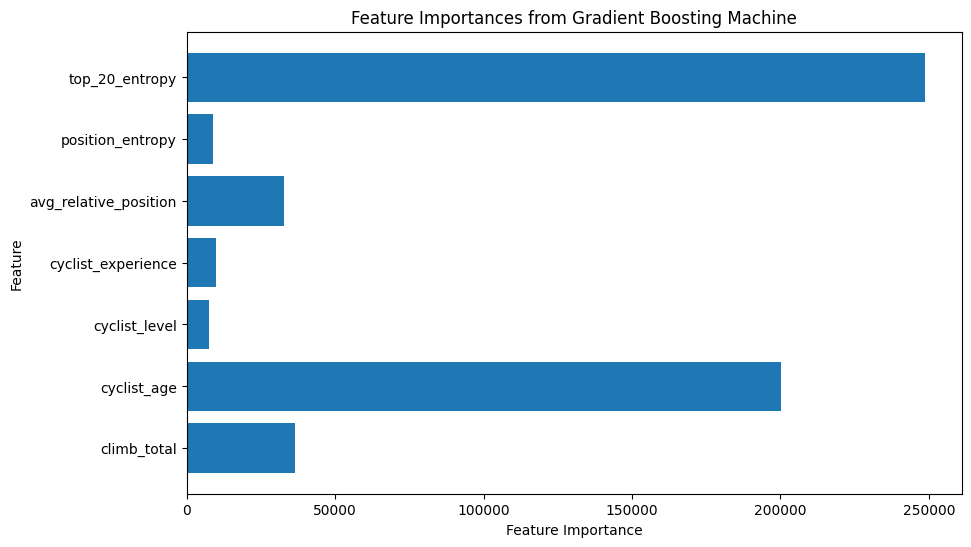

In [8]:
import matplotlib.pyplot as plt

gbm_model = best_model.named_steps['clf']

# Print feature importance
feature_importances = gbm_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(train_data.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boosting Machine')
plt.show()

In [9]:
print("gbm feture importance:")
for feature, importance in zip(train_data.columns, feature_importances):
    print(f"{feature}: {importance}")

gbm feture importance:
climb_total: 36338.73665381968
cyclist_age: 200057.82809996605
cyclist_level: 7410.736044220626
cyclist_experience: 9882.760590434074
avg_relative_position: 32676.535688221455
position_entropy: 9019.091836452484
top_20_entropy: 248606.06138264015


Recalling this is importance coming from GBM library

## **SHAP**

In [10]:
import shap

/Users/francesco/miniconda3/envs/dm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Extract the underlying model from the pipeline
gbm_model = best_model.named_steps['clf']

interventional_explanation_algorithm = shap.TreeExplainer(
    model=gbm_model,
    data=train_data,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm = shap.TreeExplainer(
    model=gbm_model,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)


In [12]:
interventional_explanations = interventional_explanation_algorithm(explanation_data)
distributional_explanations = distributional_explanation_algorithm(explanation_data)

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

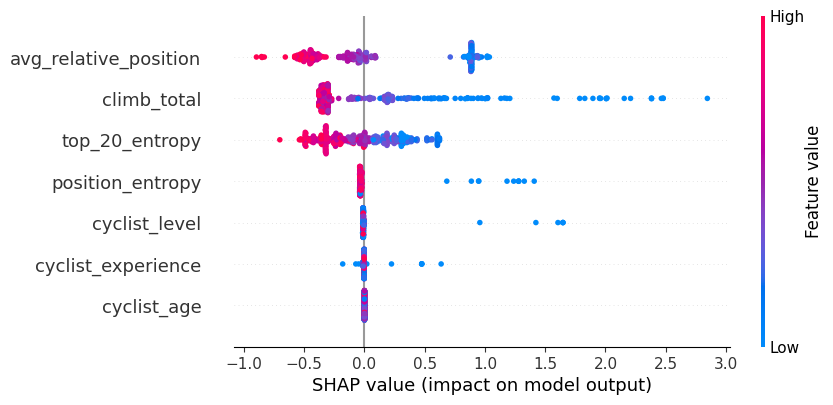

In [13]:
shap.plots.beeswarm(interventional_explanations)

The plot shows that `climb_total` and `avg_relative_position` have the strongest influence on predictions, with high climb totals contributing positively. Features like `cyclist_level` and `cyclist_experience` show less impact, while `cyclist_age` has minimal influence.

The discrepancy arises because GBM importance measures feature impact based on split frequency and impurity reduction, favoring features like `top_20_entropy`, while SHAP evaluates individual prediction contributions, offering a more balanced perspective.

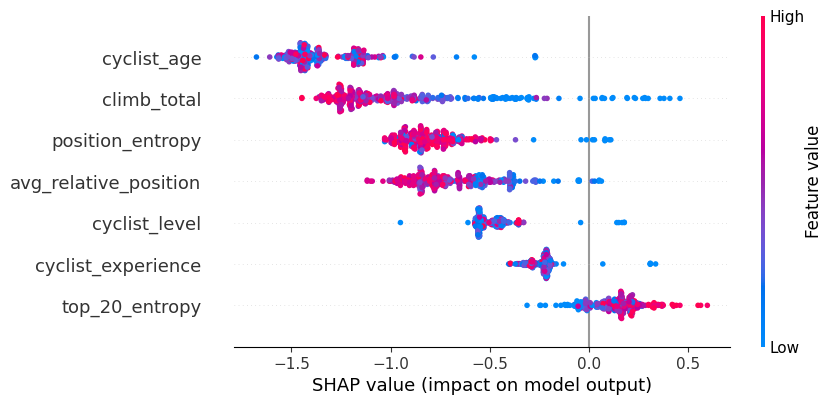

In [14]:
shap.plots.beeswarm(distributional_explanations)

Here’s a concise feature-by-feature summary of the SHAP plot:

1. **Cyclist Age**: Older cyclists (red) have a **negative impact** on the model’s output.
2. **Climb Total**: More climbs (red) are associated with **worse predictions** (negative SHAP values).
3. **Position Entropy**: Higher entropy (red) leads to **negative SHAP values**, indicating uncertainty in position hurts predictions.
4. **Average Relative Position**: Better positions (blue) correspond to **positive SHAP values**, predicting better performance.
5. **Cyclist Level**: Higher levels (red) lead to **positive SHAP values**, indicating better performance predictions.
6. **Cyclist Experience**: More experience (red) correlates with **negative SHAP values**, predicting worse outcomes.
7. **Top 20 Entropy**: Higher entropy (red) results in **negative SHAP values**, suggesting uncertainty in top rankings decreases predictions.

Overall, features like **cyclist level** and **relative position** show positive impacts, while **age**, **climb total**, and **experience** correlate with negative impacts.

In [15]:
print("Features sorted by decreasing importance for interventional method:")
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=train_data.columns.tolist())
print(interventional_explanations_df.abs().mean().sort_values(ascending=False))

print("\nFeatures sorted by decreasing importance for distributional method:")
distributional_explanations_df = pd.DataFrame(distributional_explanations.values, columns=train_data.columns.tolist())
print(distributional_explanations_df.abs().mean().sort_values(ascending=False))

Features sorted by decreasing importance for interventional method:
avg_relative_position    0.439445
climb_total              0.427925
top_20_entropy           0.258287
position_entropy         0.063045
cyclist_level            0.031866
cyclist_experience       0.011327
cyclist_age              0.000000
dtype: float64

Features sorted by decreasing importance for distributional method:
cyclist_age              1.342098
climb_total              0.965981
position_entropy         0.794868
avg_relative_position    0.683794
cyclist_level            0.498500
cyclist_experience       0.240513
top_20_entropy           0.151461
dtype: float64


Let's analyze feature importance according to shap values


Features sorted by decreasing importance for interventional method:


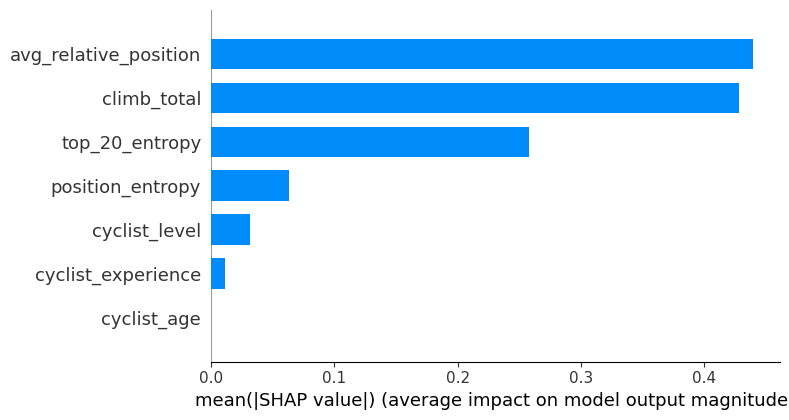


Features sorted by decreasing importance for distributional method:


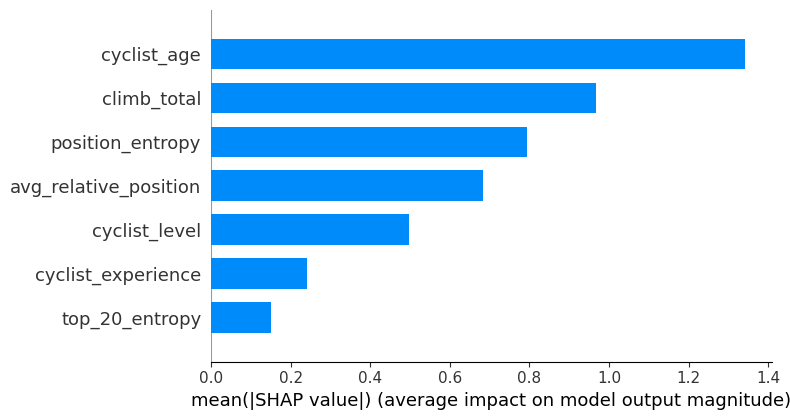

In [16]:
print("\nFeatures sorted by decreasing importance for interventional method:")
shap.summary_plot(interventional_explanations, test_data, plot_type="bar")
print("\nFeatures sorted by decreasing importance for distributional method:")
shap.summary_plot(distributional_explanations, test_data, plot_type="bar")

In [17]:
print("Features sorted by decreasing importance for interventional method:")
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=train_data.columns.tolist())
print(interventional_explanations_df.abs().mean().sort_values(ascending=False))

print("\nFeatures sorted by decreasing importance for distributional method:")
distributional_explanations_df = pd.DataFrame(distributional_explanations.values, columns=train_data.columns.tolist())
print(distributional_explanations_df.abs().mean().sort_values(ascending=False))

Features sorted by decreasing importance for interventional method:
avg_relative_position    0.439445
climb_total              0.427925
top_20_entropy           0.258287
position_entropy         0.063045
cyclist_level            0.031866
cyclist_experience       0.011327
cyclist_age              0.000000
dtype: float64

Features sorted by decreasing importance for distributional method:
cyclist_age              1.342098
climb_total              0.965981
position_entropy         0.794868
avg_relative_position    0.683794
cyclist_level            0.498500
cyclist_experience       0.240513
top_20_entropy           0.151461
dtype: float64


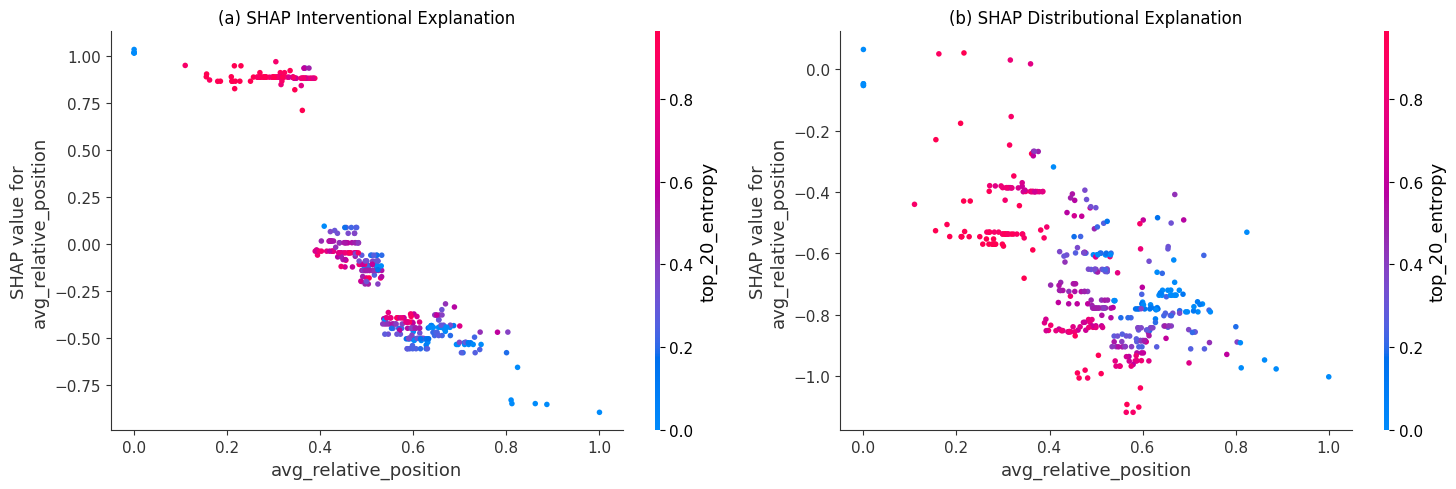

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

shap.dependence_plot("avg_relative_position", explanations["shap_interventional"], test_data, ax=ax[0], show=False)
ax[0].set_title('(a) SHAP Interventional Explanation')

shap.dependence_plot("avg_relative_position", explanations["shap_distributional"], test_data, ax=ax[1], show=False)
ax[1].set_title('(b) SHAP Distributional Explanation')

plt.tight_layout()
plt.show()

The results show a positive correlation between `top_20_entropy` and the SHAP values of `avg_relative_position`, with higher entropy values tending to lead to higher SHAP values. On the other hand, the `climb_total` variable appears to have a negative relationship with `avg_relative_position`, as higher `climb_total` values are associated with lower SHAP values. These results suggest that `top_20_entropy` has a positive influence on the model, while `climb_total` has a negative effect on the prediction of `avg_relative_position`.

### Let's visualize some decisions made one sample for classe with different explainer

let's consider negative instance 32, predicted as positive

Label for instance 32: 0
Prediction for instance 32: 1


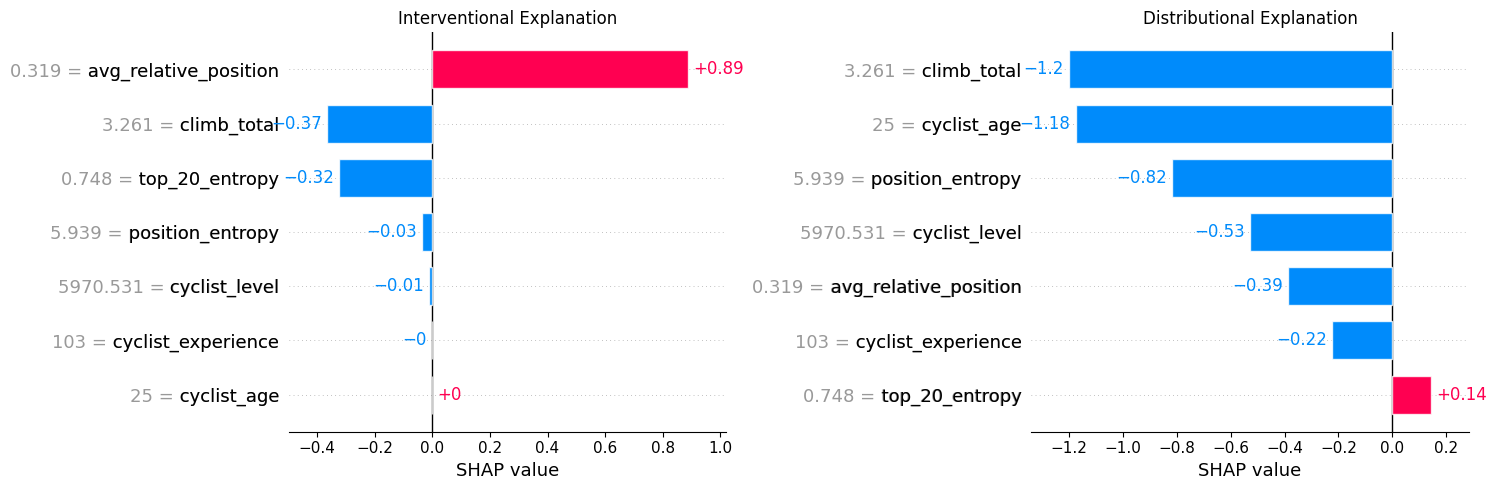

Predicted value: 1
Real value: 0


In [19]:
instance_index = 32
print("Label for instance 32:", test_labels.iloc[instance_index].values[0])
print("Prediction for instance 32:", test_prediction[instance_index])
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

shap.plots.bar(interventional_explanations[instance_index], show=False, ax=ax[0])
ax[0].set_title('Interventional Explanation')

shap.plots.bar(distributional_explanations[instance_index], show=False, ax=ax[1])
ax[1].set_title('Distributional Explanation')

plt.tight_layout()
plt.show()

print("Predicted value:", explanation_predictions[instance_index])
print("Real value:", explanation_labels.iloc[instance_index].values[0])

This plots is a local explanation for a negative data point, classified as positive. Concerning Interventional explanation, it shows that the models gives greater weight to "avg_relative_position" feature. This positively influenced the final prediction, outweighing the impact of other features, which contributed to lowering the probability of this classification.

We can hypothesize that "avg_relative_position" is closely related to high cyclist performance, such as good average race placements indicates its strength on average. As a result, the model interpreted these high values as indicators of a top-level cyclist, classifying them as class 1.

Concerning Distributional explanation the model shows that only "top_20_entropy" column countributes in leading to a positive label while others not.

----


In [20]:
import seaborn

explanation_differences = interventional_explanations.values - distributional_explanations.values
maximum_differences_per_instance = explanation_differences.max(axis=1)
maximum_differences_per_feature = explanation_differences.max(axis=0)

<Axes: ylabel='Density'>

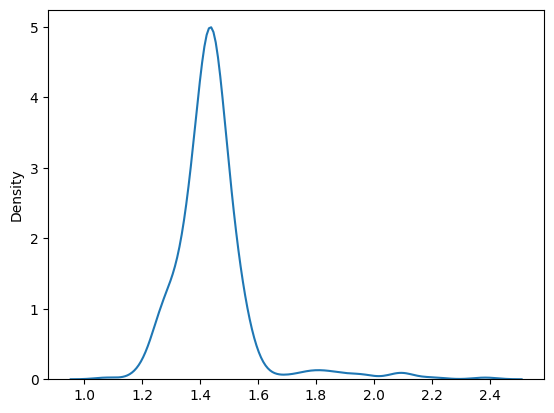

In [21]:
seaborn.kdeplot(maximum_differences_per_instance)

This plot shows that the most common difference in the interpretations of the two explainers falls between 1.4 and 1.5. Smaller and larger differences are less frequently observed across the instances.

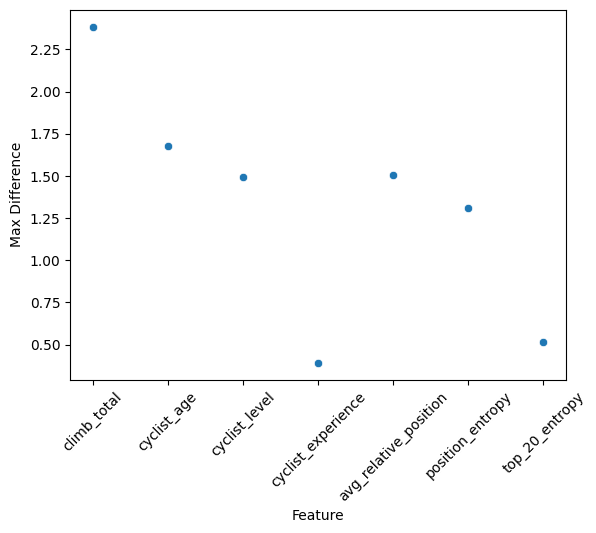

In [22]:
# Create a dataframte for better plotting
feature_differences = pd.DataFrame({
    'Feature': train_data.columns,
    'Max Difference': maximum_differences_per_feature
})

seaborn.scatterplot(data=feature_differences, x='Feature', y='Max Difference')
plt.xticks(rotation=45)
plt.show()

There is greater inconsistency between the two explanation methods for the "total climb" feature, which is considered important in both methods, while its importance is not as high in the native GBM model. In contrast, the inconsistency is lower for the "cyclist experience" feature, as it is rarely utilized by the model, which is reflected in its feature importance in the GBM model.

### Explanation analysis

Let analyze if some features generally more impactful then others adding noise to the feature and analyizing how much it impacts model's predctions 

Starting performances are:

In [23]:
pd.DataFrame(validation)

,0,1,accuracy,macro avg,weighted avg
precision,0.919014,0.379310,0.7625,0.649162,0.828614
recall,0.783784,0.656716,0.7625,0.720250,0.762500
f1-score,0.846029,0.480874,0.7625,0.663452,0.784866
support,333.000000,67.000000,0.7625,400.000000,400.000000


Let's sort features accordind to interventional explanation (we prefer this because match more with gbm importance)

In [24]:
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=train_data.columns.tolist())
features_by_importance = interventional_explanations_df.abs().mean().sort_values(ascending=False).index

print("Features sorted by decreasing importance for interventional method:")
for feature in features_by_importance:
    print("-",feature)

Features sorted by decreasing importance for interventional method:
- avg_relative_position
- climb_total
- top_20_entropy
- position_entropy
- cyclist_level
- cyclist_experience
- cyclist_age


Let's construct a set of corrupted datasets where noise at different magnitudes is inserted into the original dataset

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
test_data_norm = pd.DataFrame(scaler.fit_transform(test_data), columns=test_data.columns)

random_noise = np.random.rand(test_data_norm.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(2, 10)]

corruptions_by_feature_and_noise = dict()
for feature in features_by_importance:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise[(feature, noise_magnitude)] = test_data_norm.copy()
        corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude

Validate the model on the altered data

In [26]:
validations_by_feature_and_noise = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise.items():
    validations_by_feature_and_noise[(feature, noise)] = classification_report(test_labels, gbm_model.predict(corruption), output_dict=True, zero_division=0)

In [27]:
metric = "f1-score"
corruption_validation = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["1"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation["difference"] = corruption_validation["performance"] - validation["1"][metric]
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,avg_relative_position,0.2,0.288889,shap,-0.191985
1,avg_relative_position,0.3,0.288889,shap,-0.191985
2,avg_relative_position,0.4,0.288889,shap,-0.191985
3,avg_relative_position,0.5,0.290179,shap,-0.190696
4,avg_relative_position,0.6,0.290828,shap,-0.190047
5,avg_relative_position,0.7,0.290828,shap,-0.190047
6,avg_relative_position,0.8,0.290828,shap,-0.190047
7,avg_relative_position,0.9,0.290828,shap,-0.190047
8,climb_total,0.2,0.286344,shap,-0.194531
9,climb_total,0.3,0.286344,shap,-0.194531


The results suggest that the model generalises poorly, as even small alterations in each features cause a significant drop in performance. This suggests that the model may be overly dependent on specific feature details, compromising the overall robustness of decisions. 

In [28]:
corruption_validation.groupby("feature").describe()[["performance", "difference"]]

performance                                          \
                            count      mean       std       min       25%   
feature                                                                     
avg_relative_position         8.0  0.290020  0.000962  0.288889  0.288889   
climb_total                   8.0  0.286898  0.000628  0.286344  0.286344   
cyclist_age                   8.0  0.299381  0.008731  0.285714  0.292793   
cyclist_experience            8.0  0.289452  0.000413  0.288889  0.289371   
cyclist_level                 8.0  0.287056  0.000628  0.286344  0.286344   
position_entropy              8.0  0.287055  0.000224  0.286976  0.286976   
top_20_entropy                8.0  0.289298  0.001577  0.286976  0.288248   

                                                    difference            \
                            50%       75%       max      count      mean   
feature                                                                    
avg_relative_position  0.290503  0.290828  0.290828        8.0 -0.190855   
climb_total            0.286660  0.287611  0.287611        8.0 -0.193977   
cyclist_age            0.300268  0.307139  0.308789        8.0 -0.181494   
cyclist_experience     0.289532  0.289532  0.290179        8.0 -0.191422   
cyclist_level          0.287293  0.287611  0.287611        8.0 -0.193818   
position_entropy       0.286976  0.286976  0.287611        8.0 -0.193819   
top_20_entropy         0.289211  0.290179  0.292135        8.0 -0.191576   

                                                                         \
                            std       min       25%       50%       75%   
feature                                                                   
avg_relative_position  0.000962 -0.191985 -0.191985 -0.190371 -0.190047   
climb_total            0.000628 -0.194531 -0.194531 -0.194215 -0.193264   
cyclist_age            0.008731 -0.195160 -0.188081 -0.180606 -0.173735   
cyclist_experience     0.000413 -0.191985 -0.191503 -0.191342 -0.191342   
cyclist_level          0.000628 -0.194531 -0.194531 -0.193581 -0.193264   
position_entropy       0.000224 -0.193899 -0.193899 -0.193899 -0.193899   
top_20_entropy         0.001577 -0.193899 -0.192626 -0.191664 -0.190696   

                                 
                            max  
feature                          
avg_relative_position -0.190047  
climb_total           -0.193264  
cyclist_age           -0.172086  
cyclist_experience    -0.190696  
cyclist_level         -0.193264  
position_entropy      -0.193264  
top_20_entropy        -0.188739

In [29]:
corruption_validation.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                    \
                      count      mean       std       min       25%       50%   
noise_magnitude                                                                 
0.2                     7.0  0.288370  0.002224  0.286344  0.286976  0.287611   
0.3                     7.0  0.287616  0.001375  0.285714  0.286660  0.287611   
0.4                     7.0  0.288763  0.002083  0.286344  0.287293  0.288889   
0.5                     7.0  0.289238  0.003184  0.286344  0.287293  0.288248   
0.6                     7.0  0.291307  0.007373  0.286976  0.287293  0.289532   
0.7                     7.0  0.291465  0.007822  0.286344  0.287293  0.289532   
0.8                     7.0  0.290798  0.006372  0.286344  0.287293  0.288889   
0.9                     7.0  0.291483  0.007138  0.286344  0.287293  0.289532   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.2              0.288889  0.292906        7.0 -0.192504  0.002224 -0.194531   
0.3              0.288569  0.289532        7.0 -0.193258  0.001375 -0.195160   
0.4              0.289534  0.292453        7.0 -0.192112  0.002083 -0.194531   
0.5              0.289855  0.295775        7.0 -0.191637  0.003184 -0.194531   
0.6              0.290180  0.307692        7.0 -0.189568  0.007373 -0.193899   
0.7              0.290503  0.308789        7.0 -0.189409  0.007822 -0.194531   
0.8              0.290503  0.304762        7.0 -0.190076  0.006372 -0.194531   
0.9              0.291481  0.306954        7.0 -0.189392  0.007138 -0.194531   

                                                         
                      25%       50%       75%       max  
noise_magnitude                                          
0.2             -0.193899 -0.193264 -0.191985 -0.187968  
0.3             -0.194215 -0.193264 -0.192306 -0.191342  
0.4             -0.193581 -0.191985 -0.191341 -0.188421  
0.5             -0.193581 -0.192626 -0.191019 -0.185100  
0.6             -0.193581 -0.191342 -0.190694 -0.173182  
0.7             -0.193581 -0.191342 -0.190371 -0.172086  
0.8             -0.193581 -0.191985 -0.190371 -0.176112  
0.9             -0.193581 -0.191342 -0.189393 -0.173920

In [30]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Define the metric to assess performance drop
metric = "f1-score"

# Initialize a list to store performance drops
performance_drops = []

# Get the original performance
original_performance = classification_report(test_labels, gbm_model.predict(test_data), output_dict=True, zero_division=0)
original_metric_value = original_performance["1"][metric]

# Iterate over each feature
for feature in test_data.columns:
    # Drop the feature from the training and test data
    train_data_dropped = train_data.drop(columns=[feature])
    test_data_dropped = test_data.drop(columns=[feature])
    
    # Train a new GBM model with the same parameters
    gbm_model_dropped = LGBMClassifier(**gbm_model.get_params())
    gbm_model_dropped.fit(train_data_dropped, train_labels.values.ravel())
    
    # Predict and assess performance
    test_predictions_dropped = gbm_model_dropped.predict(test_data_dropped)
    performance_dropped = classification_report(test_labels, test_predictions_dropped, output_dict=True, zero_division=0)
    dropped_metric_value = performance_dropped["1"][metric]
    
    # Calculate performance drop
    performance_drop = original_metric_value - dropped_metric_value
    performance_drops.append((feature, performance_drop))

# Create a dataframe to store the results
performance_drop_df = pd.DataFrame(performance_drops, columns=["Feature", "Performance Drop"])
performance_drop_df = performance_drop_df.sort_values(by="Performance Drop", ascending=False)
print(performance_drop_df)

                 Feature  Performance Drop
3     cyclist_experience         -0.228571
1            cyclist_age         -0.235294
2          cyclist_level         -0.240741
4  avg_relative_position         -0.247619
5       position_entropy         -0.256881
6         top_20_entropy         -0.270833
0            climb_total         -0.285714


By removing one feature at a time, we observe a significant drop in the F1-score for class 1. This indicates that eliminating even a single feature from the training set substantially impacts overall performance, particularly the model's ability to balance its predictions. Specifically, it diminishes the model's effectiveness in handling class 1.

## **LORE**

Support functions

In [31]:
feature_indices = {
    'climb_total': 0,
    'cyclist_age': 1,
    'cyclist_level': 2,
    'cyclist_experience': 3,
    'avg_relative_position': 4,
    'position_entropy': 5,
    'top_20_entropy': 6
}

def format_counterfactual_explanation(explanation):
    formatted_explanation = []
    for rule in explanation:
        premises = " AND ".join([f"{condition['att']} {condition['op']} {(condition['thr']*scaler.scale_[feature_indices[condition["att"]]]) + scaler.mean_[feature_indices[condition["att"]]]}" for condition in rule['premise']])
        formatted_explanation.append(f"IF {premises} THEN {rule['class_name']} = {rule['cons']}")
    return formatted_explanation

def reverse_transform(record, var, mean):
    return record * var + mean

def normalize_premise(premise, feature_indices, scaler):
    return {
        'thr': reverse_transform(premise['thr'], scaler.scale_[feature_indices[premise["att"]]], scaler.mean_[feature_indices[premise["att"]]]),
        'att': premise['att'],
        'op': premise['op'],
        'is_continuous': premise['is_continuous']
    }

def format_explanation(explanation):
    explanation.expDict['rule']['premise'] = list(map(
        lambda x: normalize_premise(x, feature_indices, scaler),
        explanation.expDict['rule']['premise']
    ))

    explanation.expDict['crules'][0]['premise'] = list(map(
        lambda x: normalize_premise(x, feature_indices, scaler),
        explanation.expDict['crules'][0]['premise']
    ))
    
    return explanation


In [32]:
from xailib.explainers.lore_explainer import LoreTabularExplainer


lore_explanation_algorithm = LoreTabularExplainer(gbm_model)
configuration = {
    "neigh_type": "rndgen",
    "size": 1000,
    "ocr": 0.1,
    "ngen": 100
}

train_data = StandardScaler().fit_transform(train_data)
train_data = pd.DataFrame(train_data, columns=train_df.drop(columns=columns_to_drop).columns)
lore_train_data = pd.concat((train_data, train_labels), axis="columns")
lore_explanation_algorithm.fit(lore_train_data, "top_20", config=configuration)

### Explaining a data from class 0, predicted as class 1

In [33]:
indexes = test_labels[(test_labels['top_20'] == 1) & test_prediction==1].index
print("Indexes in training data with both test and predicted label being 1:")
print(indexes.tolist())

Indexes in training data with both test and predicted label being 1:
[9, 12, 19, 24, 34, 38, 49, 71, 101, 102, 106, 115, 134, 145, 148, 153, 165, 166, 226, 227, 228, 234, 239, 241, 248, 255, 261, 264, 276, 297, 299, 303, 338, 343, 348, 358, 360, 361, 362, 364, 372, 388, 390, 397]


In [34]:
explanation = lore_explanation_algorithm.explain(train_data.iloc[32].values)
explanation = format_explanation(explanation)

Extracting rules from the tree

In [35]:
rule = explanation.plotRules()

Extracting counterfactual rules from the tree

In [36]:
rule = explanation.plotCounterfactualRules()

Local Fidelity (accuracy of the model w.r.t. the model, computed on the generated neighborhood)

In [37]:
explanation.expDict["fidelity"]

0.9786055883827756

### Explaining a data from class 0, predicted as class 0

In [38]:
indexes = test_labels[(test_labels['top_20'] == 0) & test_prediction==0].index
print("Indexes in training data with both test and predicted label being 0:")
print(indexes.tolist())
young_cyclists_indexes = test_data.loc[indexes][test_data['cyclist_age'] < 21].index
print("Indexes with cyclist_age < 21:")
print(young_cyclists_indexes.tolist())

Indexes in training data with both test and predicted label being 0:
[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 45, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113, 114, 115, 117, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 139, 140, 141, 143, 144, 145, 147, 148, 149, 150, 153, 154, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 186, 188, 190, 192, 193, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 246, 24

In [39]:
explanation = lore_explanation_algorithm.explain(train_data.iloc[399].values)
explanation = format_explanation(explanation)

Extracting rules from the tree

In [40]:
rule = explanation.plotRules()

Extracting counterfactual rules from the tree

In [41]:
rule = explanation.plotCounterfactualRules()

Local Fidelity (accuracy of the model w.r.t. the model, computed on the generated neighborhood)

In [42]:
explanation.expDict["fidelity"]

0.9836919334568681

## **LIME**

In [43]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show
from tqdm import tqdm


set_visualize_provider(InlineProvider())

In [44]:
non_numeric_features = train_df.select_dtypes(include=['object']).columns
print(non_numeric_features)

Index(['_url', 'name', 'cyclist', 'cyclist_team', 'duration'], dtype='object')


Only numerical features are taken

In [45]:
train_data = train_data.select_dtypes(include=[np.number])  

In [46]:
from interpret.blackbox import LimeTabular
explanations = dict()

train_data_norm = pd.DataFrame(scaler.transform(train_data), columns=train_data.columns)

lime_explanation_algorithm = LimeTabular(best_model, train_data_norm)
explanations["lime"] = np.array([np.array(e["scores"])
                                 for e in tqdm(lime_explanation_algorithm.explain_local(train_data_norm, train_labels)._internal_obj["specific"])])

100%|██████████| 400/400 [00:00<00:00, 534817.21it/s]


In [47]:
import pandas


metric = "f1-score"
corruption_validation_lime = pandas.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["weighted avg"][metric], "lime")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_lime["difference"] = corruption_validation_lime["performance"] - validation["weighted avg"][metric]

corruption_validation = pandas.concat((corruption_validation, corruption_validation_lime))
corruption_validation_lime

,feature,noise_magnitude,performance,algorithm,difference
0,avg_relative_position,0.2,0.119746,lime,-0.665120
1,avg_relative_position,0.3,0.119746,lime,-0.665120
2,avg_relative_position,0.4,0.119746,lime,-0.665120
3,avg_relative_position,0.5,0.129017,lime,-0.655849
4,avg_relative_position,0.6,0.133614,lime,-0.651251
5,avg_relative_position,0.7,0.133614,lime,-0.651251
6,avg_relative_position,0.8,0.133614,lime,-0.651251
7,avg_relative_position,0.9,0.133614,lime,-0.651251
8,climb_total,0.2,0.100896,lime,-0.683970
9,climb_total,0.3,0.100896,lime,-0.683970




#### **Stable and Robust Features**

- **avg_relative_position** and **climb_total** <br> 
  These features are highly stable. Adding noise does not significantly impact the model's performance, indicating that their contribution to the predictions is insignificant. 

- **top_20_entropy** <br>
  This feature is completely insensitive to noise, suggesting that it is either irrelevant to the model or not utilized in its decision-making process.


#### **Sensitive or Complex Features**

- **position_entropy** <br>
  This feature is influential but also sensitive to noise. The model's performance drops as noise increases.

- **cyclist_level** and **cyclist_experience** <br>
  Both features show improved performance as noise increases, indicating they capture more complex or nonlinear relationships in the data. The noise helps the model generalize better, probabily reducing overfitting. Cyclist_level shows a slight improvement instead Cyclist_experience shows a more consistent improvement, indicating that it is a more significant feature for the model.

- **cyclist_age** <br>
  This characteristic exhibits moderate instability, with performance variations becoming more significant at higher noise levels and results worsening as noise increases.

The introduction of noise had varying effects on the analyzed variables, revealing that some features are stable, while others show greater or more complex impacts. These results suggest that variables like cyclist_experience are key to the model and require particular attention, while others might be less significant or even unused by the model. 

### Explaining data with 0 label and prediction being 1

Nota: the data is the same instances explained in LORE

In [48]:
instance_index = 32
print("Label: ",test_labels.iloc[instance_index].values[0])
print("Predicted value: ", test_prediction[instance_index])

instance = test_data.iloc[[instance_index]]

explanation_0 = lime_explanation_algorithm.explain_local(instance)
explanation_0.visualize(0)

Label:  0
Predicted value:  1


### Explaining data with label and prediction being 0

Nota: the data is the same instances explained in LORE

In [49]:
instance_index = 399
print("Label: ",test_labels.iloc[instance_index].values[0])
print("Predicted value: ", test_prediction[instance_index])

instance = test_data.iloc[[instance_index]]

explanation_0 = lime_explanation_algorithm.explain_local(instance)
explanation_0.visualize(0)

Label:  0
Predicted value:  0
